In [1]:
# import from different python files 
from circuit_top_tools import *
from analysis_tools import * 
import mdtraj as md 
from cycler import cycler
from matplotlib import colormaps 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns 
import pickle

In [2]:
# set up matplotlib parameters 
plt.rc('font', family='sans-serif', weight='normal', size=14)
plt.rc('axes', linewidth=1.5)

max_num_clusters = 5
viridis = colormaps['viridis'].resampled(max_num_clusters)
default_cycler = cycler(color=viridis(range(max_num_clusters)))
# set the visualization style 
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=default_cycler)
plt.rcParams["font.size"]
plt.rcParams.update({"font.size":12, 'ytick.labelsize': '12', 'xtick.labelsize': '12', 'legend.fontsize': '10', 'axes.titlesize': '12'})
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

Trajectory file paths and trajectory loading

In [3]:
# load in the paths of trajectories and initialize global variables
traj_path = "/Users/f006j60/Robustelli_Group/IAPP/s20g/pbc_trj_3.8us_trunc/pbc_1.xtc"
top_path = "../../structures/prot_s20g.pdb"
traj_dir = "/Users/f006j60/Robustelli_Group/IAPP/wt/pbc_trj_4us_trunc/"
outdir = "./outdir_circuit_top_tinker/"
psystem = "s20g_iapp_apo"
helixpdb = '/Users/f006j60/git/IAPP/structures/helix_wt.pdb'
prot_len = 38 
stride = 10

In [4]:
# create an md traj object from the trajectory that you want 
trj = md.load(traj_path, top = top_path, stride=stride)
top = trj.topology
trj

<mdtraj.Trajectory with 3551 frames, 533 atoms, 38 residues, and unitcells at 0x107613dc0>

Now, we can compute everything we need for analysis that will be carried out later on the clusters that are identified. 

In [5]:
h_res = []
for res in trj.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
residue_offset = 0
hres_renum = np.asarray(h_res)+residue_offset
print(hres_renum)
dssp_all = md.compute_dssp(trj, simplified=True)
dssp_all_array = np.array(dssp_all)
dssp_all_H, dssp_all_E = dssp_convert(dssp_all)

helixBB = md.load_pdb(helixpdb)
Sa_total = calc_Sa(trj, helixBB)
rg_CA = calc_rg(trj)

# generate the contact map of the whole trajectory 
contact_map, distance_map = contact_map_avg(trj, prot_len-1)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


/Users/f006j60/git/IAPP/analysis/IAPP_circuit_top/analysis_tools.py:114: RuntimeWarning: invalid value encountered in divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


In [6]:
dsspH = np.copy(dssp_all)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
print(TotalH)

[ 7  8  9 ... 12  4 10]


In [7]:
# save this 
np.save(outdir+psystem+"_Rg_total" + ".npy", rg_CA)
np.save(outdir+psystem+"_Sa_total" + ".npy", Sa_total)
np.save(outdir+psystem+"_H_total" + ".npy", TotalH)

In [8]:
dsspE = np.copy(dssp_all)
dsspE[dsspE == 'H'] = 0
dsspE[dsspE == 'E'] = 1
dsspE[dsspE == 'C'] = 0
dsspE[dsspE == 'NA'] = 0
dsspE = dsspE.astype(int)
TotalE = np.sum(dsspE, axis=1)
print(dsspE)
np.save(outdir+psystem+"_E_total" + ".npy", TotalE)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Define the cutoff distances that you'd like for the analysis

In [9]:
# Format
fileformat = 'pdb'

# cutoff_distance, maximal distance (Ångström) between two atoms that will count as an atom-atom contact.
# cutoff_numcontacts, minimum number of contacts between two residues to count as a res-res contact.
# exclude_neighbour, number of neighbours that are excluded from possbile res-res contacts.

# CT variables
cutoff_distance =       10
cutoff_numcontacts =    1 # any contact counts as a contact
exclude_neighbour =     1

# there might be more functionality to add 
# #Length Filtering
# length_filtering =      0
# filtering_distance =    0
# length_mode =           '<'

# #Energy filtering
# energy_filtering =      0
# energy_filtering_mode = '+'

# # Exporting
# plot_figures =          1
# exporting_psc =         0
# exporting_cmap3 =       0
# exporting_mat   =       0

In [10]:
# os.remove(outdir + psystem + ".npy")

In [11]:
# circuit_matrix, circuit_model, map_dict = compute_circuit_top_model(trj, cutoff_distance=cutoff_distance, cutoff_numcontacts=cutoff_numcontacts, exclude_neighbour=exclude_neighbour)
# # save the circuit_model as a .npy file 
# np.save(outdir + psystem + ".npy", circuit_model, allow_pickle=False, fix_imports=False)
# np.save(outdir + psystem + "matrix.npy", circuit_matrix, allow_pickle=False, fix_imports=False)

In [4]:
# circuit_model = np.load(outdir+psystem+".npy")
circuit_matrix = np.load(outdir+psystem+"matrix.npy")

In [13]:
# scaler = MinMaxScaler()
# scaler.fit(circuit_model)
# scaled_model = scaler.transform(circuit_model)

# pca = PCA(n_components=2)
# pca.fit(scaled_model)
# # scaling the model to see if that changes things! 
# reduced = pca.fit_transform(scaled_model)
# PC1 = reduced[:, 0]
# PC2 = reduced[:, 1]

In [14]:
# # # save the PCs
# np.save(outdir+psystem+"PCs.npy", reduced, allow_pickle=False, fix_imports=False)

In [21]:
reduced = np.load(outdir+psystem+"PCs.npy")
PC1 = reduced[:, 0]
PC2 = reduced[:, 1]

/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_41569/1480363946.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cdict = cm.get_cmap("nipy_spectral")._segmentdata


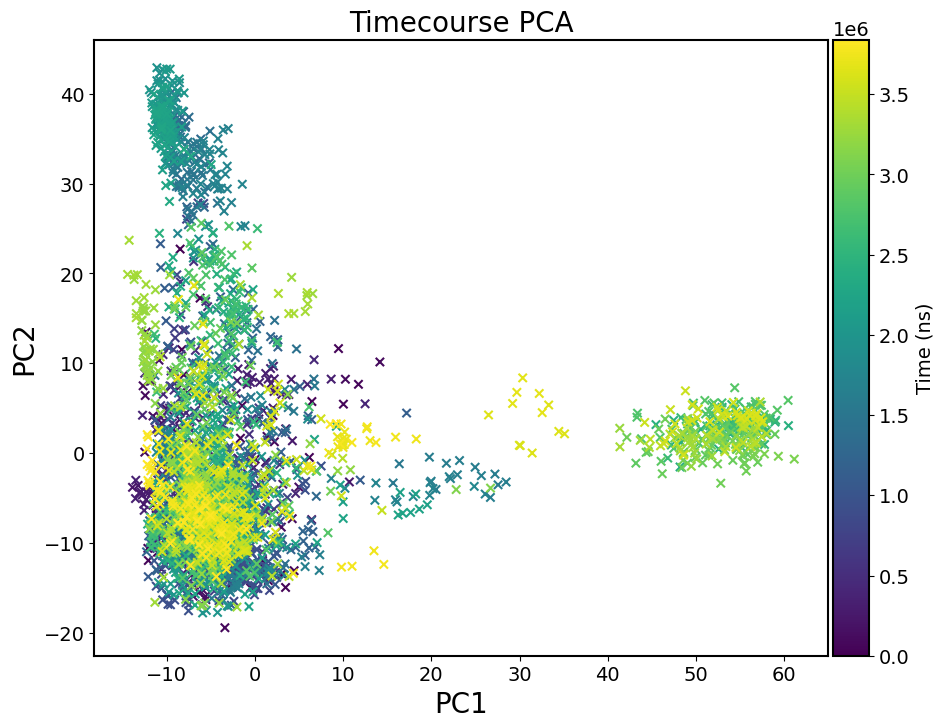

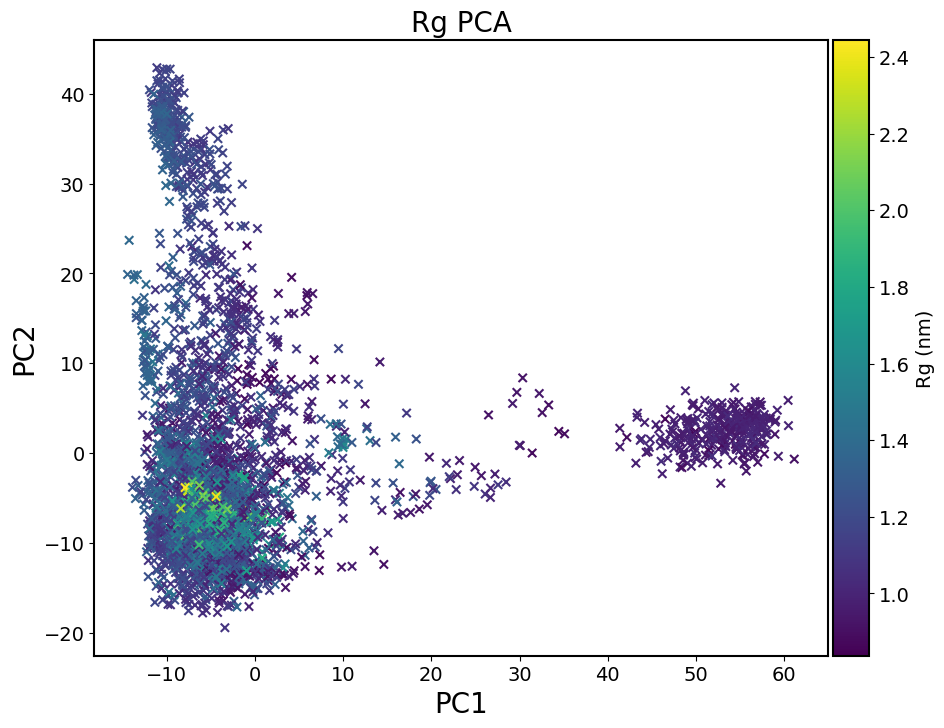

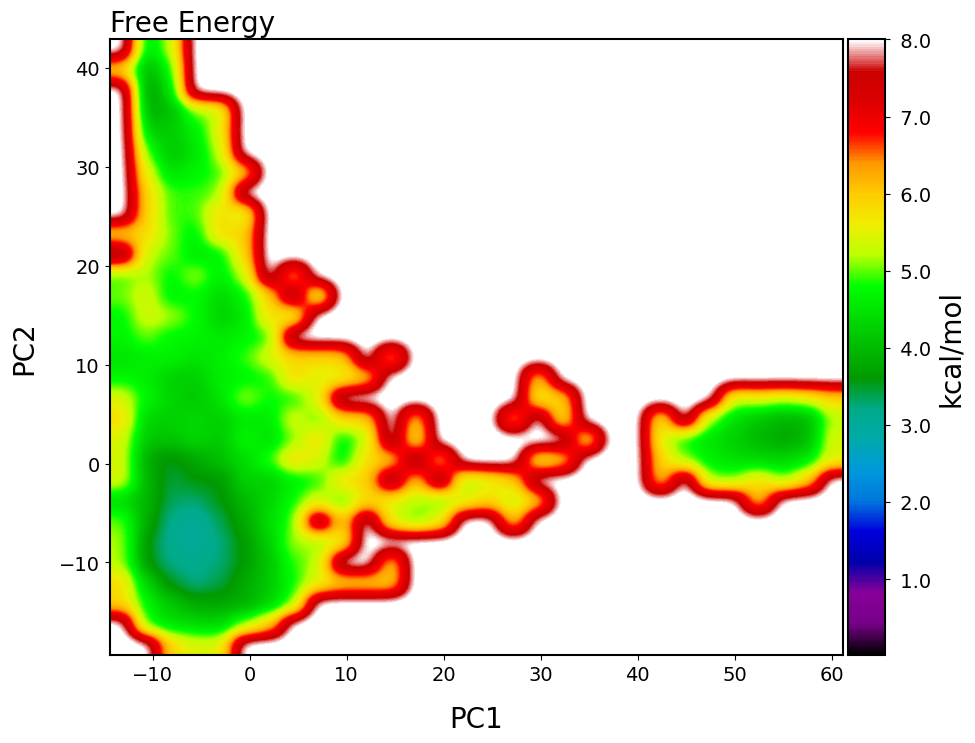

In [16]:
# make a new color map 
cdict = cm.get_cmap("nipy_spectral")._segmentdata
cdict["red"][-1]=(1,1,1)
cdict["green"][-1]=(1,1,1)
cdict["blue"][-1]=(1,1,1)
n_cmap = colors.LinearSegmentedColormap("new_cmap", cdict)
ax1 = plt_project_time(PC1, PC2, trj.n_frames, time=trj.time[-1])
ax2 = plt_project_rg(PC1, PC2, trj)
ax3 = plt_free_energy(PC1, PC2, col_map= n_cmap, title="Free Energy" ) 


Figure out why the free energy looks a bit off! 

Here we can try different clusters and evaluate, which number of clusters is best

KMeans clustering analysis for s20g_iapp_apo
__________________________________________________________________________________
n_cluster	silhouette score	Inertia
2	 	 0.735829		709615.893794573


/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3	 	 0.691550		240237.40925659513
4	 	 0.552671		156942.5296334129
5	 	 0.561797		122201.84133598425


/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


6	 	 0.443793		91824.19794038477
7	 	 0.409225		78344.58397874582


/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


8	 	 0.407758		68136.83025609583
9	 	 0.403435		59160.39526665399


/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


10	 	 0.402285		53220.98076658263
11	 	 0.401478		48707.50256303655


/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


12	 	 0.396748		44817.50168295193
13	 	 0.359967		41636.51745819684


/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14	 	 0.357809		38273.498073863935
15	 	 0.371903		35609.197420742414


/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


16	 	 0.357216		33235.337830484474
17	 	 0.366612		30415.077346193473


/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


18	 	 0.363207		28731.005705542048
19	 	 0.369759		27043.473055587423
__________________________________________________________________________________


/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


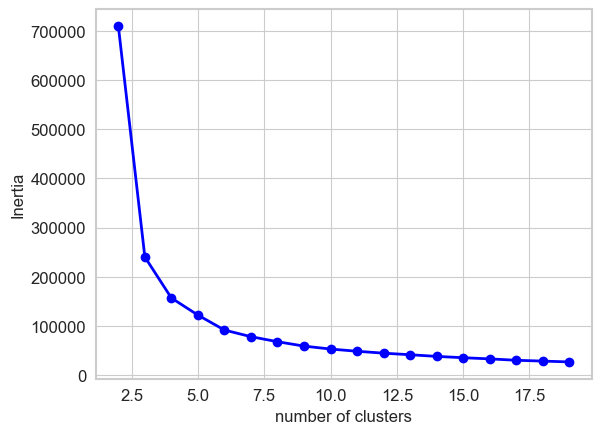

In [22]:
# clusters between 2 and 15, but could define otherwise
# benchmark kmeans 
data = np.column_stack((PC1,PC2), )
bench_k_means(psystem, data, clusters = np.arange(2,20,1))

/Users/f006j60/miniconda3/envs/circuit_top/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


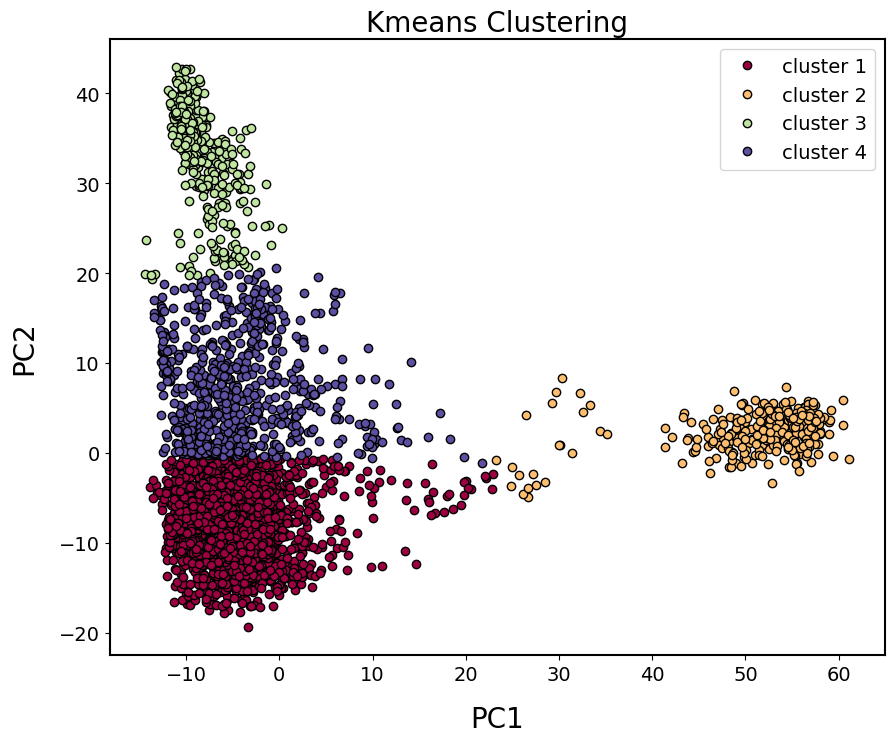

In [20]:
n_cluster=4
ax, kmean_labels, centers = kmeans_cluster(PC1, PC2, clusters=n_cluster, title = "Kmeans Clustering")

Now we can assign those clusters and do further plotting/analyses

In [21]:
# # create a c_dict for each cluster  
# c_dict = {}
# for i in range(n_cluster):
#     ind = np.where(kmean_labels==i)[0]
#     c_dict[i] = np.array(ind)

# c_dict_reorder = {}
# # reorder clusters by % helix, largest to smallest
# order = np.argsort([np.average(TotalH[c_dict[c]]) for c in range(n_cluster)])[::-1]
# for c in range(n_cluster): 
#     c_dict_reorder[c] = c_dict[order[c]]

# # define the reordered element
# c_dict = c_dict_reorder

# # save this dictionary, so that the overall stats can be saved, while still being able to index the clusters 
# import pickle 

# with open(outdir+psystem+"_kmeans_cluster_indices.pkl", "wb") as f: 
#     pickle.dump(c_dict, f)

In [22]:
with open(outdir+psystem+"_kmeans_cluster_indices.pkl", "rb") as f: 
    test_dict = pickle.load(f)

(array([0. , 1. , 2.5]),
 [Text(1, 0.0, ' 0.0'), Text(1, 1.0, ' 1.0'), Text(1, 2.5, ' 2.5')])

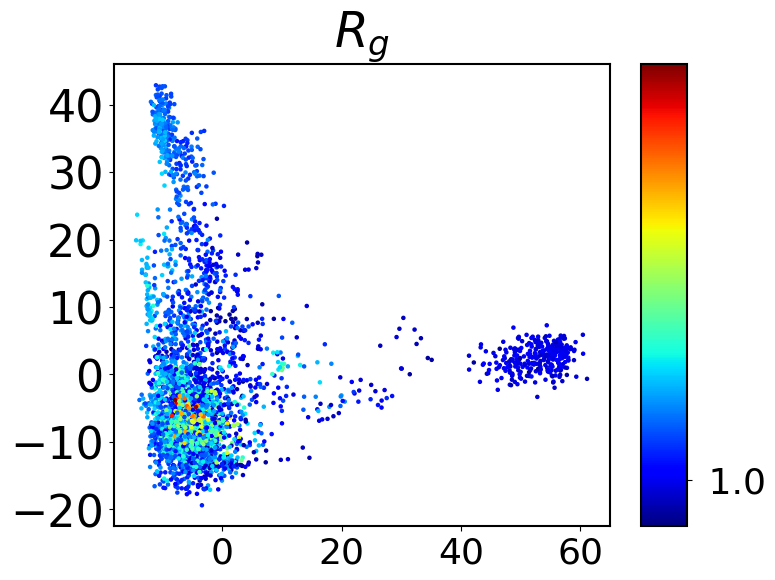

In [23]:
fig = plt.figure(figsize=(8, 6))
im = plt.scatter(PC1,PC2,c=rg_CA,s=5, cmap='jet')
#plt.imshow(a, interpolation='gaussian', extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,1,2.5]
#plt.xlim(0, 24.9)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
#plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.title(r'$R_g$', size=35)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
#plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')

(array([ 0,  5, 10, 20, 25]),
 [Text(1, 0, ' 0.0'),
  Text(1, 5, ' 5.0'),
  Text(1, 10, ' 10.0'),
  Text(1, 20, ' 20.0'),
  Text(1, 25, ' 25.0')])

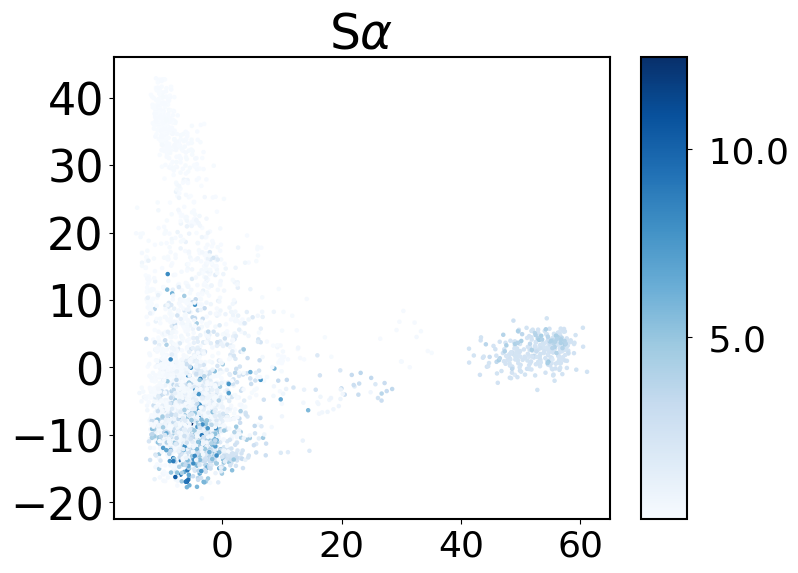

In [24]:
fig = plt.figure(figsize=(8, 6))
im = plt.scatter(PC1,PC2,c=Sa_total,s=5, cmap='Blues')
#plt.imshow(a, interpolation='gaussian', extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 5, 10, 20, 25]
#plt.xlim(0, 24.9)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
#plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.title(r'S$\alpha$', size=35)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
#plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')

(array([ 0, 10, 20, 30, 40]),
 [Text(1, 0, ' 0.0'),
  Text(1, 10, ' 10.0'),
  Text(1, 20, ' 20.0'),
  Text(1, 30, ' 30.0'),
  Text(1, 40, ' 40.0')])

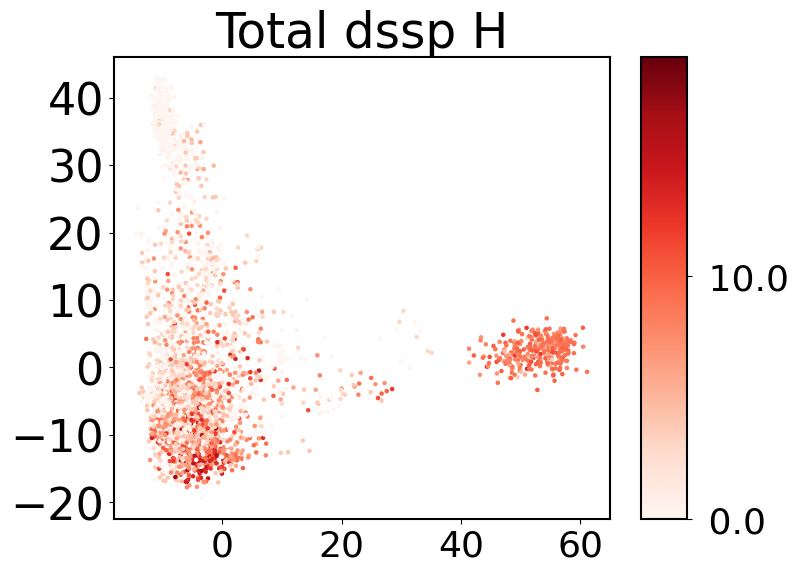

In [25]:
fig = plt.figure(figsize=(8, 6))
im = plt.scatter(PC1, PC2, c=TotalH ,s=5, cmap='Reds')
#plt.imshow(a, interpolation='gaussian', extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,10,20,30,40]
#plt.xlim(0, 24.9)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.title("Total dssp H", size=35)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.yticks(size='26')

/Users/f006j60/git/IAPP/analysis/IAPP_circuit_top/analysis_tools.py:114: RuntimeWarning: invalid value encountered in divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


([<matplotlib.axis.XTick at 0x16c0abca0>,
 [Text(1, 0, '1'),
  Text(3, 0, '3'),
  Text(5, 0, '5'),
  Text(7, 0, '7'),
  Text(9, 0, '9'),
  Text(11, 0, '11'),
  Text(13, 0, '13'),
  Text(15, 0, '15'),
  Text(17, 0, '17'),
  Text(19, 0, '19'),
  Text(21, 0, '21'),
  Text(23, 0, '23'),
  Text(25, 0, '25'),
  Text(27, 0, '27'),
  Text(29, 0, '29'),
  Text(31, 0, '31'),
  Text(33, 0, '33'),
  Text(35, 0, '35'),
  Text(37, 0, '37')])

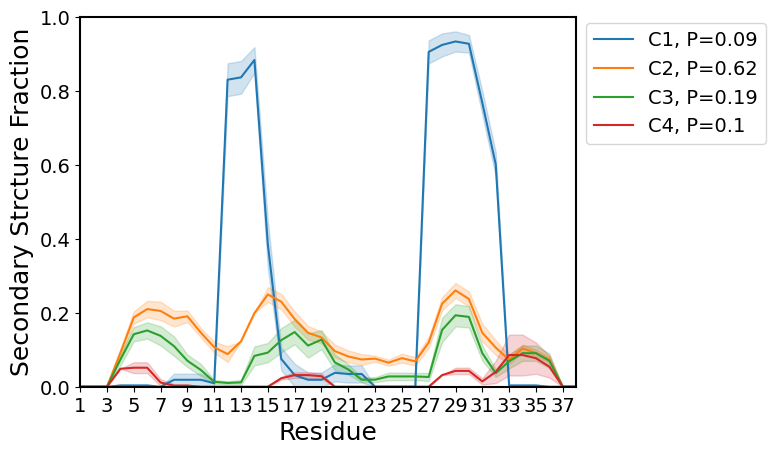

In [26]:
for i in range(0, n_cluster):
    H1_H, H1_E = dssp_convert(dssp_all[c_dict[i]])
    plt.plot(hres_renum, H1_H[:, 0], label='C%s' %
             str(i+1) + ", P=" + str(np.round(len(c_dict[i])/trj.n_frames, 2)), color="C" + str(i))
    plt.fill_between(hres_renum, H1_H[:, 0]-H1_H[:, 1],
                     H1_H[:, 0]+H1_H[:, 1], alpha=0.2, color="C" + str(i))
plt.ylim(0, 1.0)
plt.xlim(1,38)
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01), fontsize=14, ncol=1)
plt.xticks(np.arange(1,38,2))

In [27]:
hres_renum

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38])

In [28]:
np.save(outdir + psystem + "_secondary_structure_str" + ".npy", dssp_all)

In [29]:
contact_maps = []
distance_maps = []
# trjs = []
for t in set(kmean_labels): 
    temptrj = trj.slice(np.where(kmean_labels == t)[0])
    print(temptrj.n_frames)
    # trjs.append(trj)
    # contact map 
    final_map, final_distance = contact_map_avg(temptrj, prot_len-1)
    contact_maps.append(final_map)
    distance_maps.append(final_distance)

2199
319
350
683


In [30]:
sequence_ol = []
for i in range(0, prot_len - 1):
    sequence_ol.append(str(trj.topology.residue(i).code))
# add the cap 
sequence_ol.append("   NH2")
print(sequence_ol)

['K', 'C', 'N', 'T', 'A', 'T', 'C', 'A', 'T', 'Q', 'R', 'L', 'A', 'N', 'F', 'L', 'V', 'H', 'S', 'G', 'N', 'N', 'F', 'G', 'A', 'I', 'L', 'S', 'S', 'T', 'N', 'V', 'G', 'S', 'N', 'T', 'Y', '   NH2']


In [31]:
trj = md.load(traj_path, top = top_path, stride=stride)
top = trj.topology
trj

<mdtraj.Trajectory with 3551 frames, 533 atoms, 38 residues, and unitcells at 0x16be89ac0>

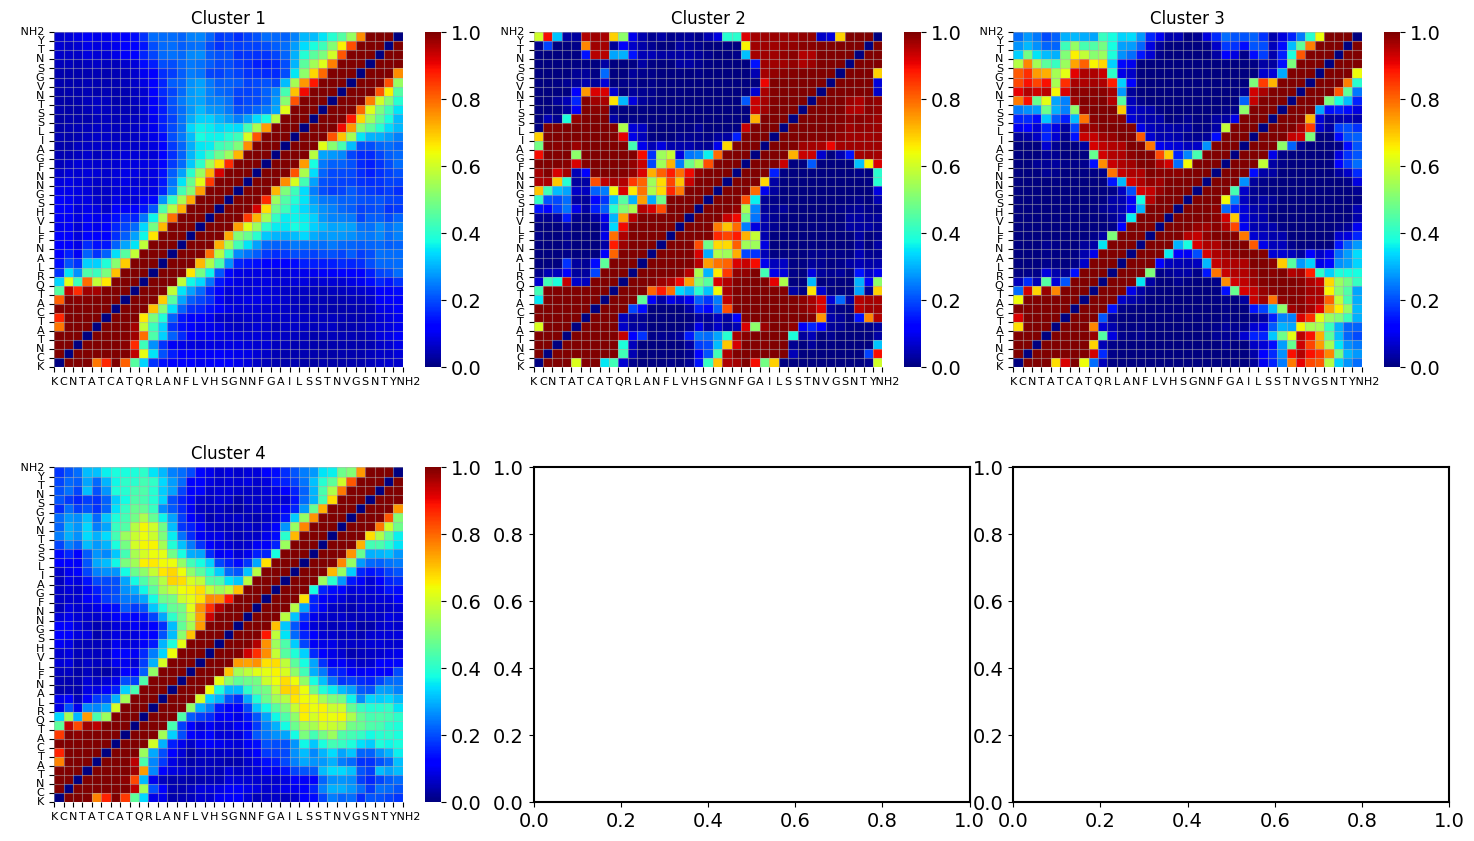

In [32]:
import seaborn as sns 
num_rows = 2
num_cols = 2

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))

# Loop through the axes and images to populate the subplots
for i, (ax, c_map) in enumerate(zip(axes.flat, contact_maps)):
    im = sns.heatmap(c_map, cmap='jet', ax=ax)
    ax.grid(which='both', alpha=0.5)
    ax.set_xticks(range(0,38), sequence_ol, rotation=0, size=8)
    ax.set_yticks(range(0,38), sequence_ol, rotation=0, size=8)
    ax.invert_yaxis()
    
    # Add a title to the subplot
    ax.set_title(f'Cluster {i+1}', fontsize=12)  # Customize title as needed

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Increased vertical spacing

# Show the plot
plt.show()

In [33]:
# def make_dual_map(trj, prot_len=38, ligand_idx = 38):
#     contact_maps = []
#     for i in range(0, prot_len):
#         # print(i)
#         contact_map = []
#         for j in range(0, prot_len):
#             dist1 = md.compute_contacts(trj, [[i, ligand_idx]], scheme='closest-heavy')
#             dist2 = md.compute_contacts(trj, [[j, ligand_idx]], scheme='closest-heavy')
#             array1 = np.asarray(dist1[0]).astype(float)
#             array2 = np.asarray(dist2[0]).astype(float)
#             contact1 = np.where(array1 < 0.5, 1, 0)
#             contact2 = np.where(array2 < 0.5, 1, 0)
#             sum = contact1 + contact2
#             contact = np.where(sum == 2, 1, 0)
#             contacts = np.average(contact)
#             contact_map.append(contacts)
#         contact_maps.append(contact_map)
#     final_map = np.asarray(contact_maps).astype(float)
#     return final_map

In [34]:
# dual_contact_maps = []
# for t in set(kmean_labels): 
#     temptrj = trj.slice(np.where(kmean_labels == t)[0])
#     # dual contact map 
#     dual_contact_map = make_dual_map(temptrj, prot_len-1)
#     dual_contact_maps.append(dual_contact_map)

In [35]:
# import seaborn as sns 
# num_rows = 2
# num_cols = 2

# # Create a figure and axes for subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))

# # Loop through the axes and images to populate the subplots
# for i, (ax, d_map) in enumerate(zip(axes.flat, dual_contact_maps)):
#     im = sns.heatmap(d_map, cmap='jet', ax=ax)
#     ax.grid(which='both', alpha=0.5)
#     ax.set_xticks(range(0,38), sequence_ol, rotation=0, size=8)
#     ax.set_yticks(range(0,38), sequence_ol, rotation=0, size=8)
#     ax.invert_yaxis()
    
#     # Add a title to the subplot
#     ax.set_title(f'Cluster {i+1}', fontsize=12)  # Customize title as needed

# # Adjust spacing between subplots
# plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Increased vertical spacing

# # Show the plot
# plt.show()

/Users/f006j60/git/IAPP/analysis/IAPP_circuit_top/analysis_tools.py:114: RuntimeWarning: invalid value encountered in divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


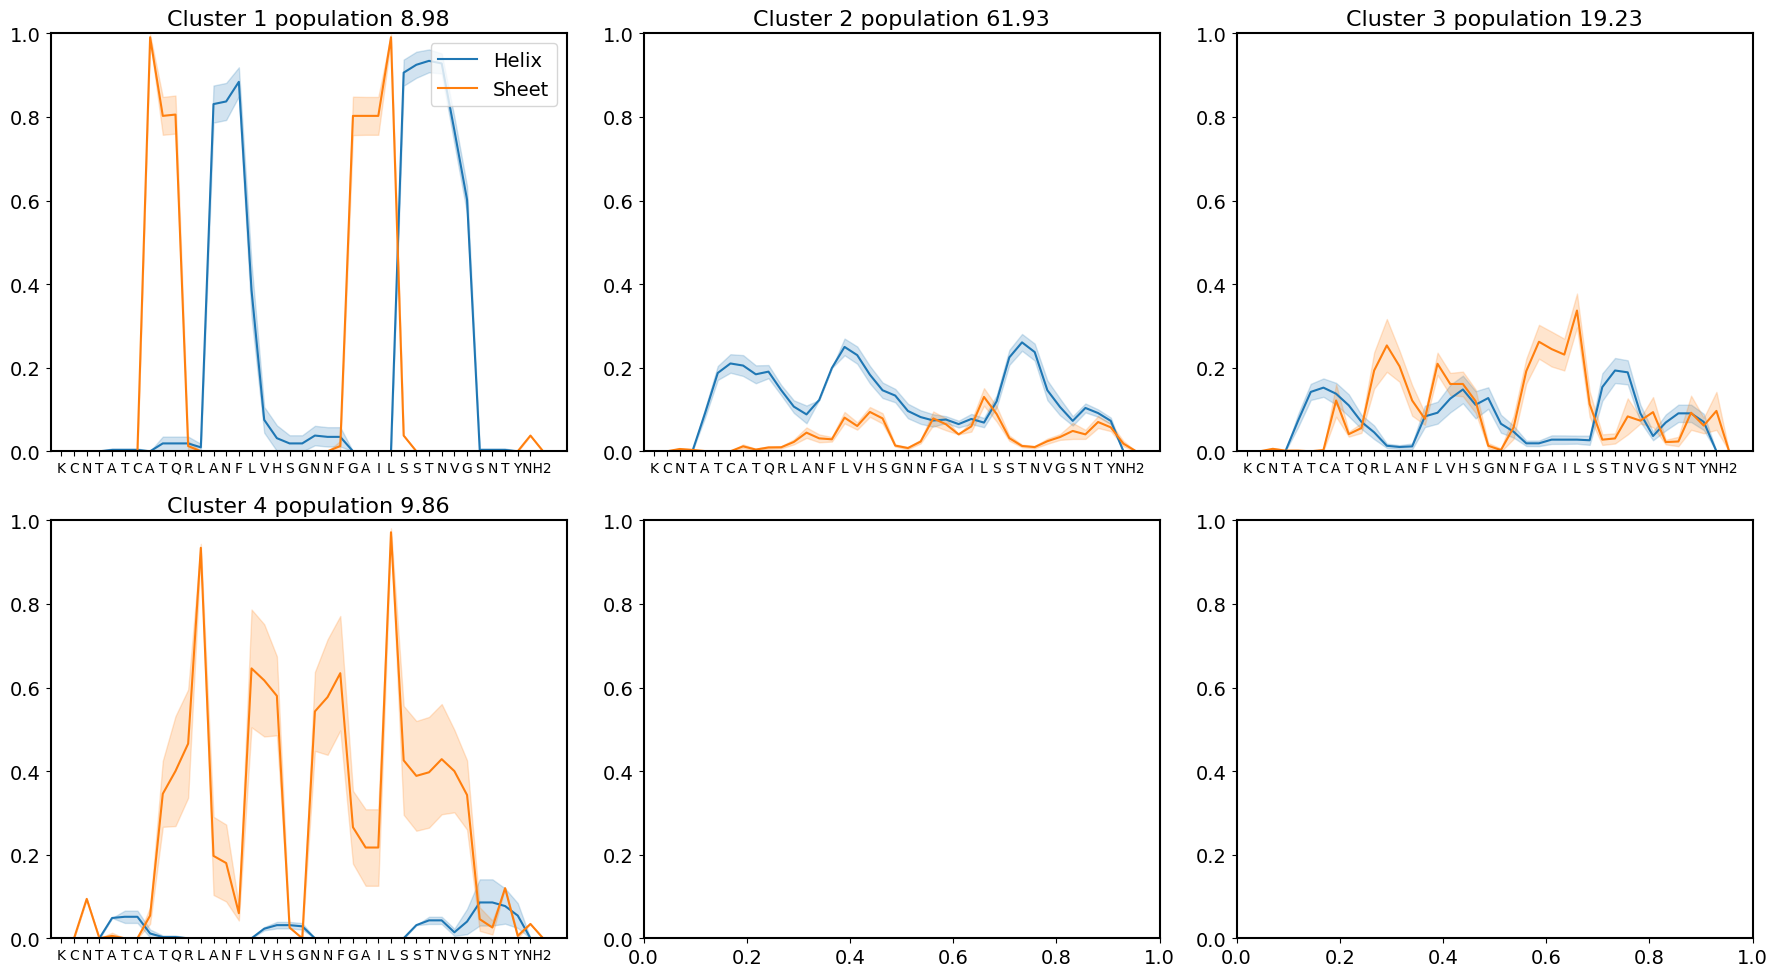

In [36]:
num_rows = 2
num_cols = 2

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))

# Loop through the axes and images to populate the subplots
for i, ax in enumerate(axes.flat):
    if i > n_cluster-1: 
        break
    H1_H, H1_E = dssp_convert(dssp_all[c_dict[i]])

    ax.plot(hres_renum, H1_H[:, 0], label='Helix', color="C0")
    ax.fill_between(hres_renum, H1_H[:, 0]-H1_H[:, 1],
                     H1_H[:, 0]+H1_H[:, 1], alpha=0.2, color="C0")
    
    ax.plot(hres_renum, H1_E[:, 0], label='Sheet', color="C1")
    ax.fill_between(hres_renum, H1_E[:, 0]-H1_E[:, 1],
                     H1_E[:, 0]+H1_E[:, 1], alpha=0.2, color="C1")
    
    ax.set_xticks(range(38), sequence_ol, fontsize=10)
    ax.set_ylim(0,1.0)
    # Add a title to the subplot
    ax.set_title(f'Cluster {i+1} population ' + str(np.round((c_dict[i].size/trj.n_frames * 100), decimals=2)), fontsize=16)  # Customize title as needed

# add legend only to last cluster
axes[0,0].legend(loc = "upper right")
# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Increased vertical spacing
plt.tight_layout()
# Show the plot
plt.show()

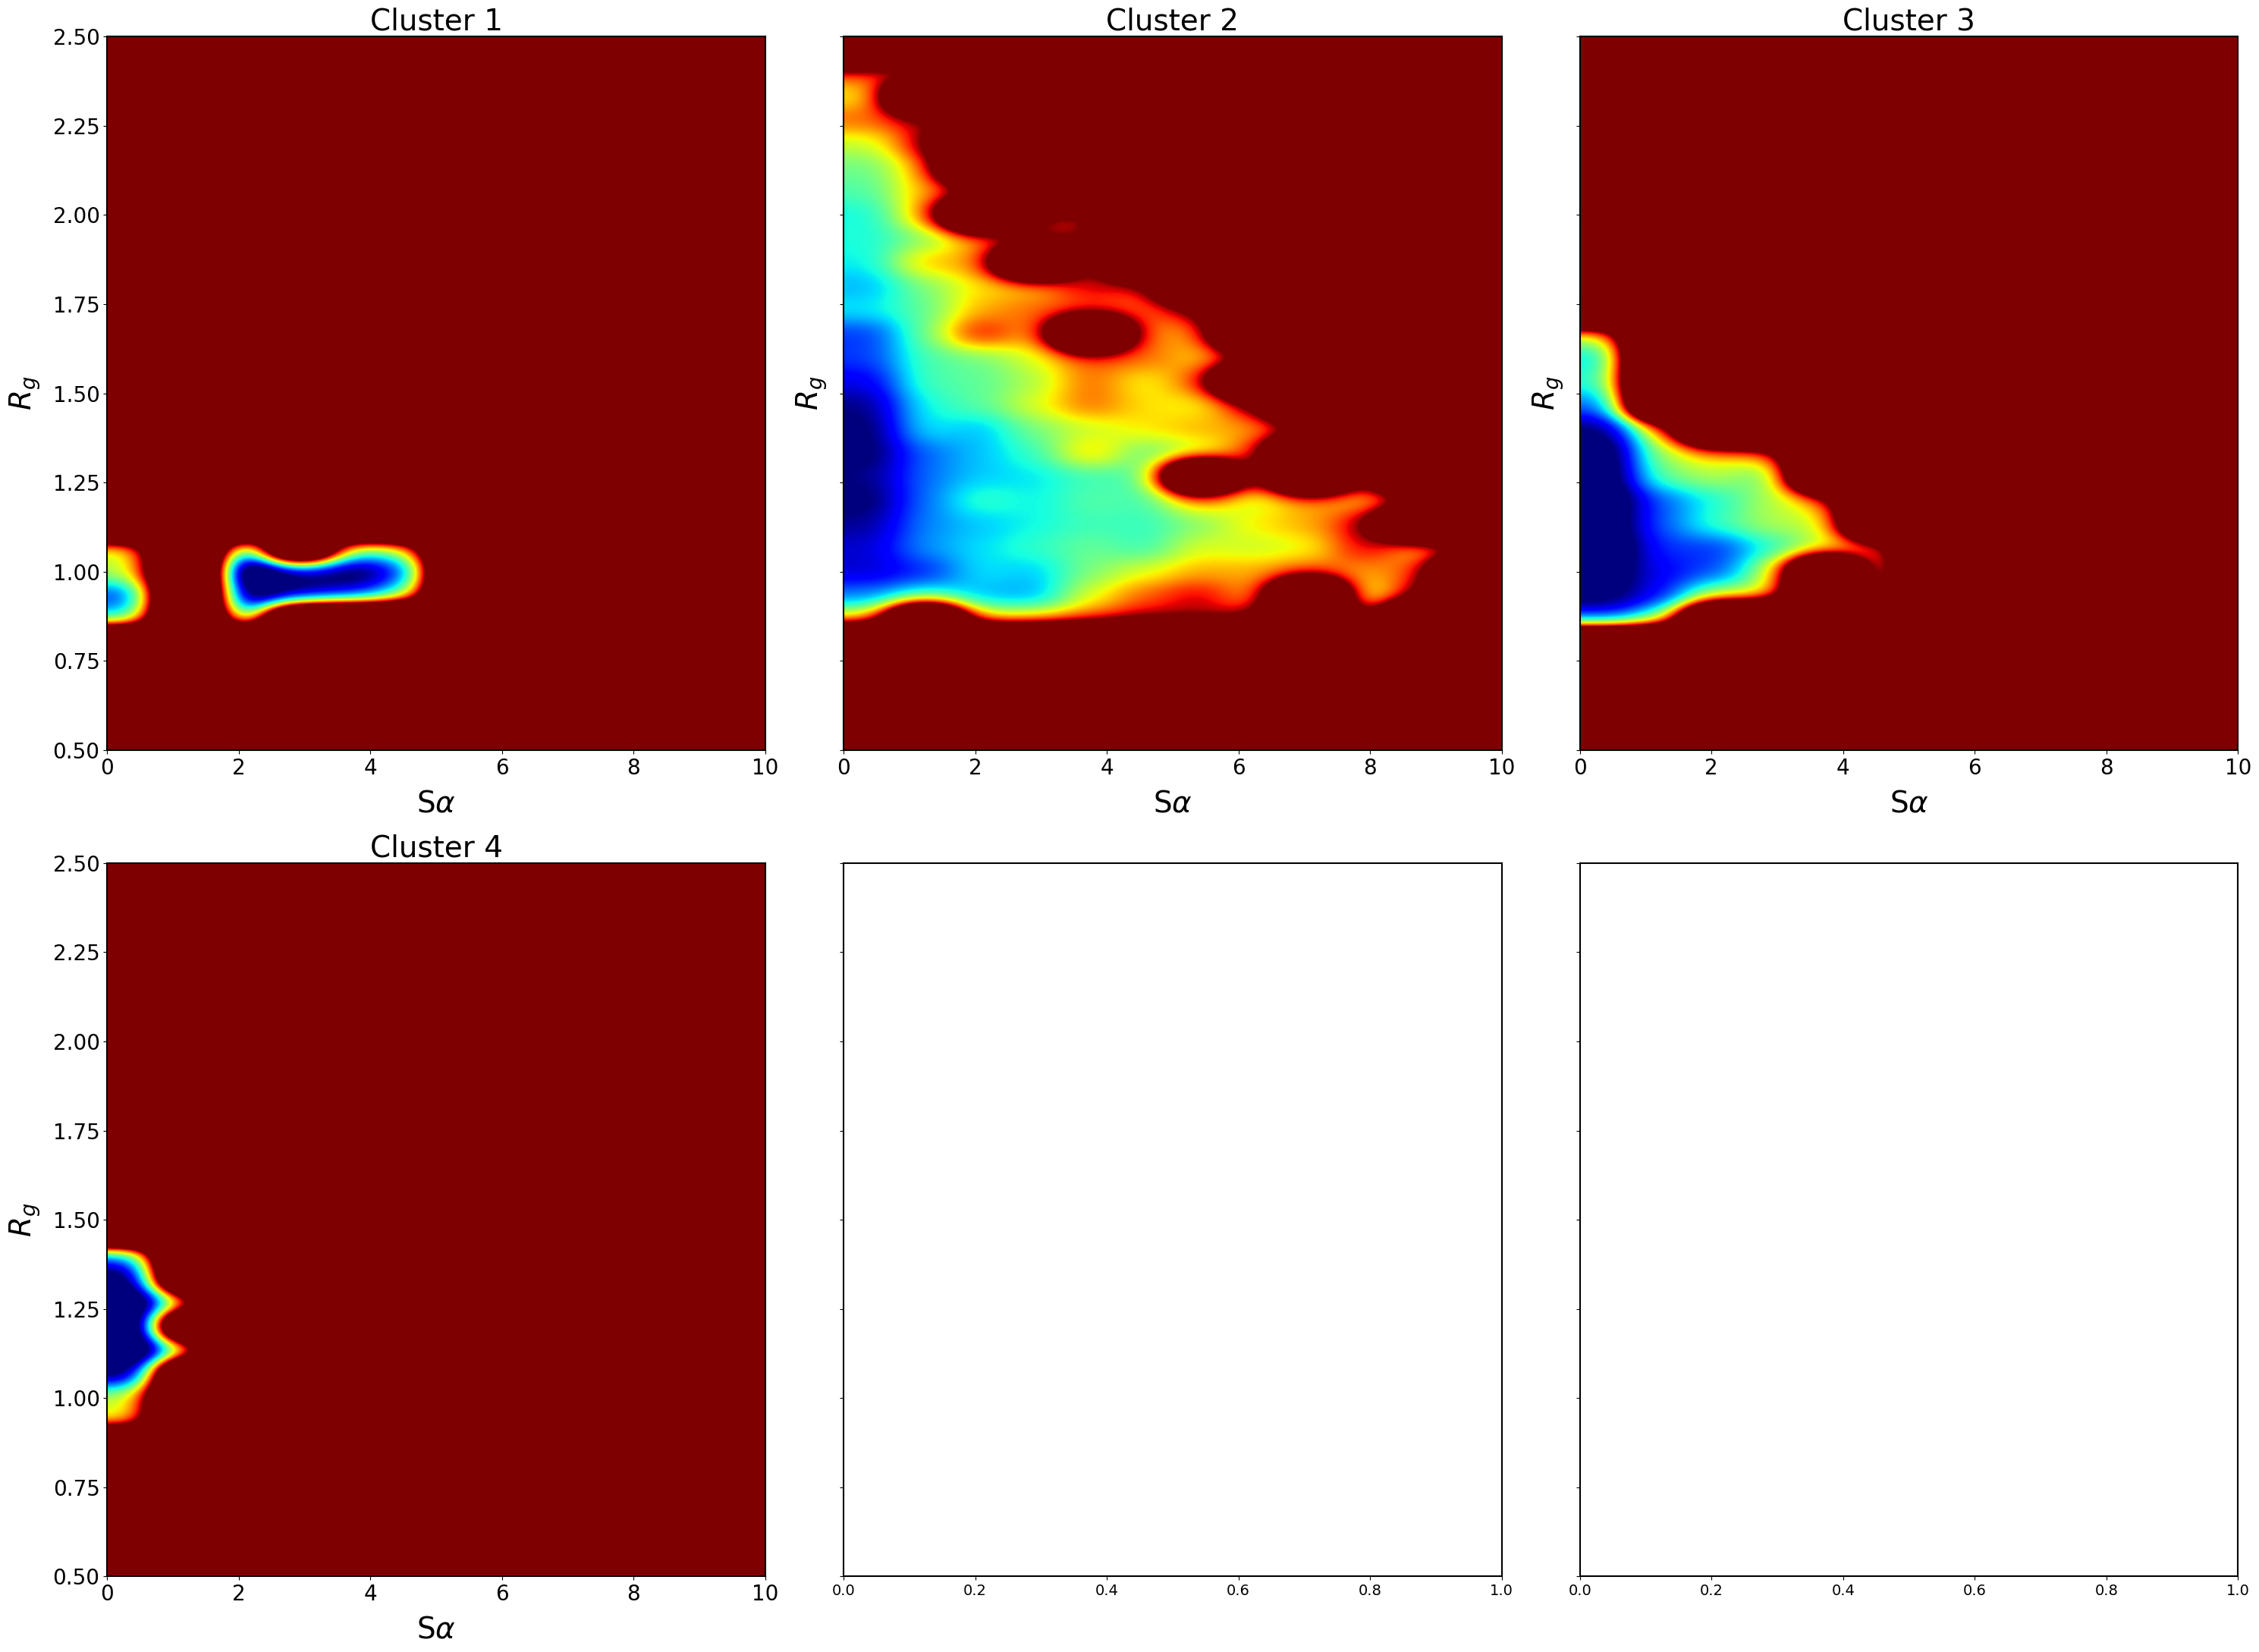

In [37]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 22), sharey=True)

for i, ax in enumerate(axes.flat):
    if i > n_cluster-1: 
        break
    
    frame_ind = c_dict[i]

    a, xedges, yedges = np.histogram2d(rg_CA[frame_ind], Sa_total[frame_ind], 30, [
        [0.5, 2.5], [0, 25.0]], density=True, weights=None)
    a = np.log(np.flipud(a)+.000001)
    T = 300
    a = -(0.001987*T)*a

    im = ax.imshow(a, interpolation='gaussian', extent=[
        yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
    im.set_clim(0.1, 3)
    ax.set_xlim(0, 10)
    ax.set_ylim(0.5,2.5)
    ax.set_ylabel("$R_g$", size=28, labelpad=10)
    ax.set_xlabel(r'S$\alpha$', size=28, labelpad=10)
    ax.set_title('Cluster %s' % str(i+1), size=28)
    ax.tick_params(axis='both', labelsize=20)
plt.tight_layout()

Show the image created using the plots below. I will be creating an 

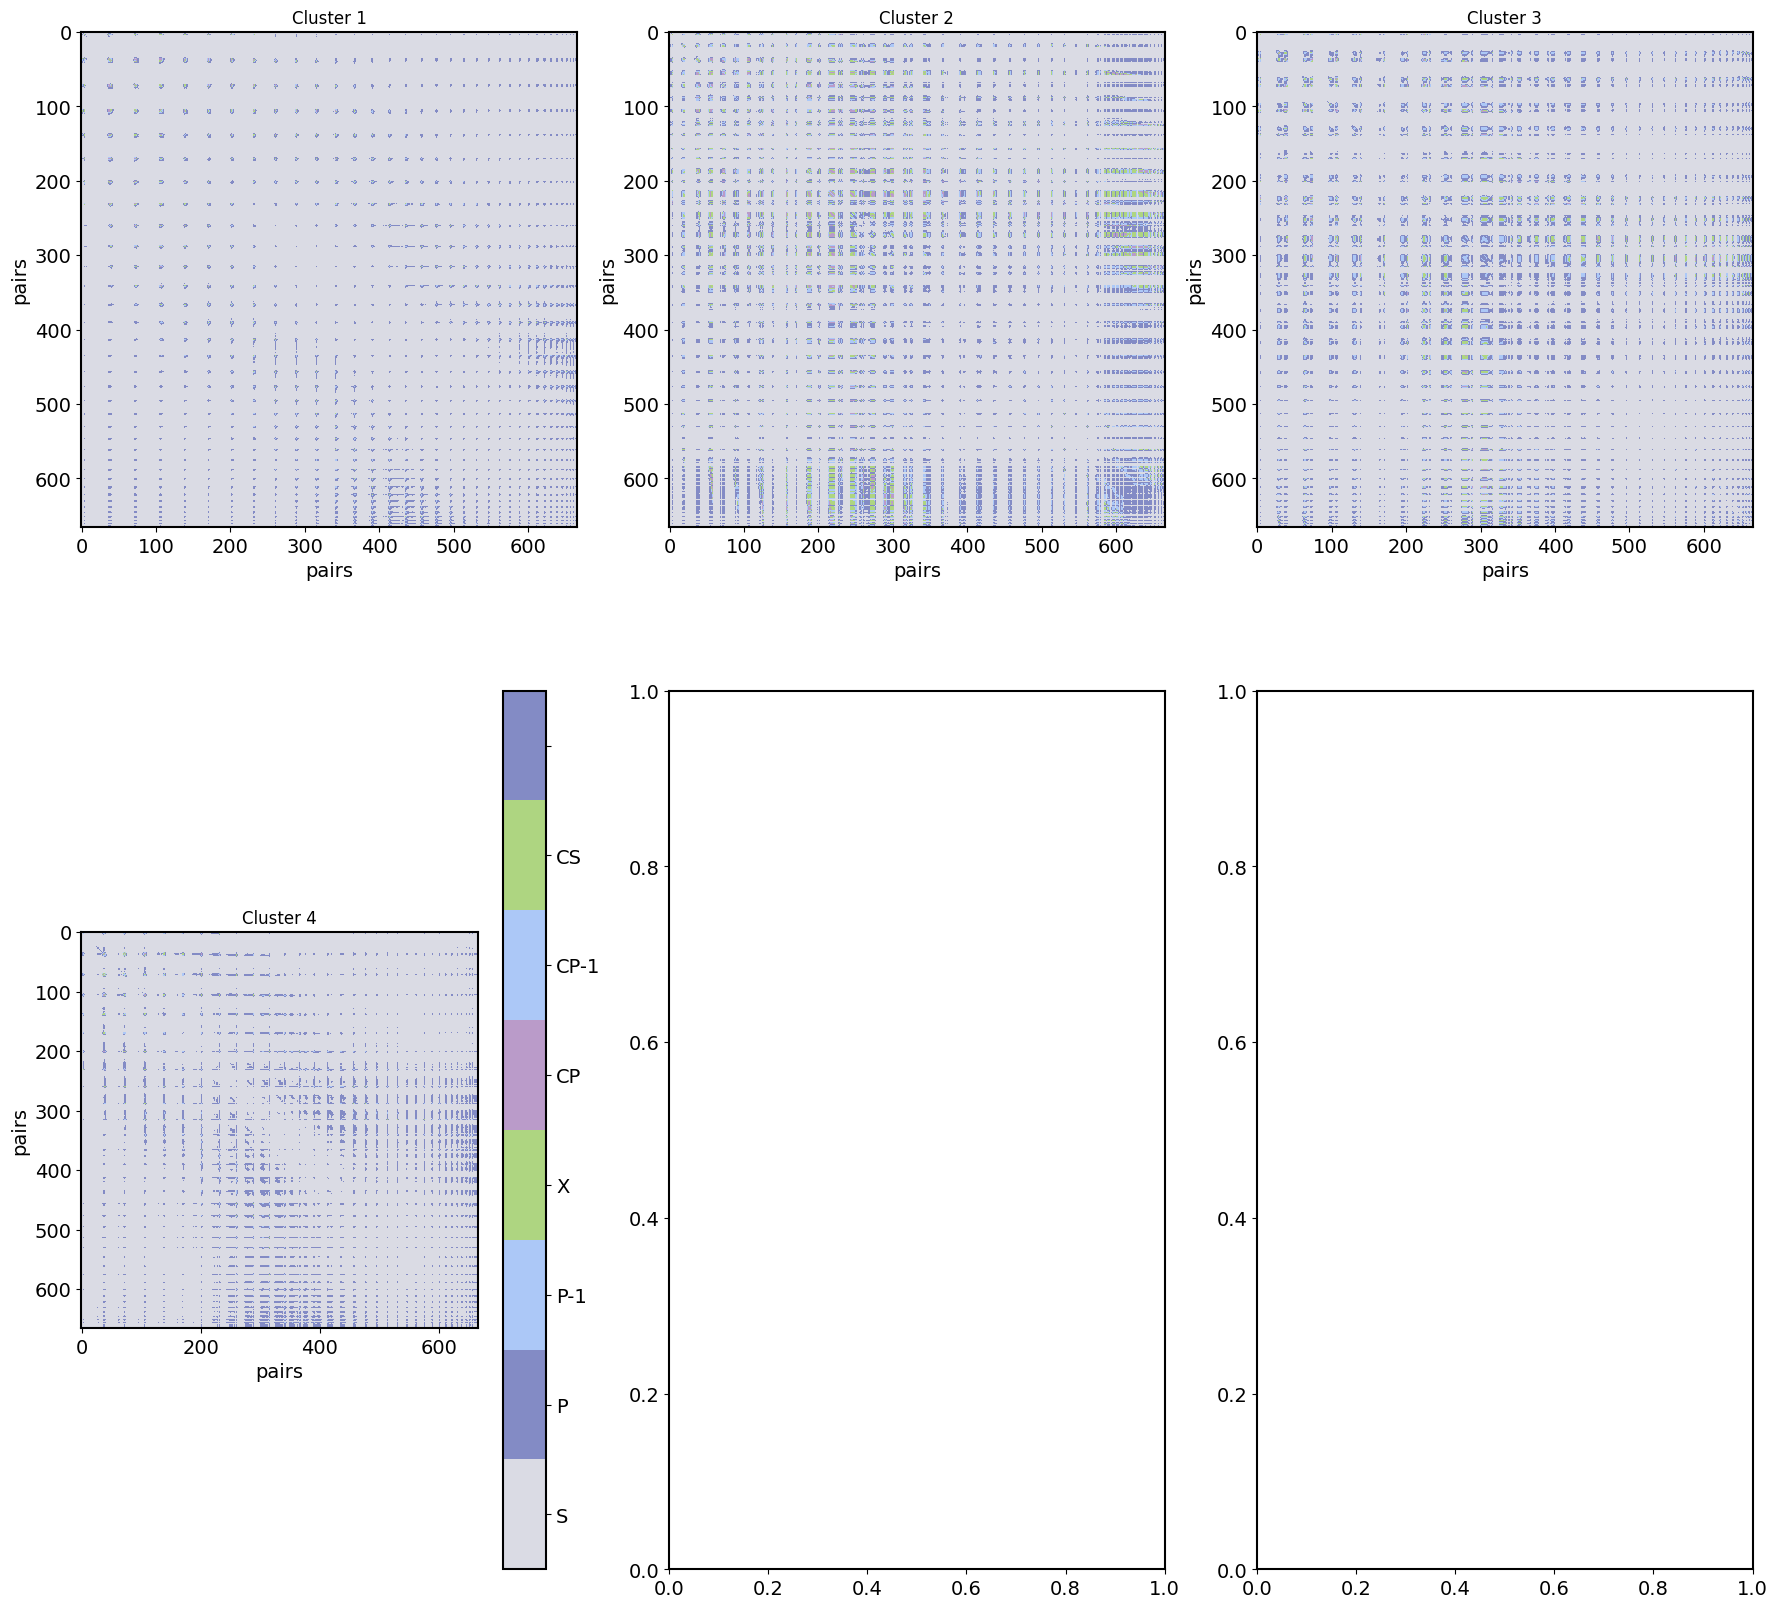

In [38]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#create custom colormap
newcolors = np.array([[218/255, 219/255, 228/255,1], #grey - 
                    [131/255, 139/255, 197/255,1],    #purple S
                    [172/255,200/255,247/255,1],       #blue P
                    [174/255,213/255,129/255,1],         #mint green P-1
                    [186/255, 155/255, 201/255,1],        #red purple - X
                    [172/255, 200/255, 247/255,1],        #blue P
                    [174/255, 213/255, 129/255,1],        #mint green
                    [131/255,139/255, 197/255,1]])        #purple S
newcmp = ListedColormap(newcolors)
color = plt.get_cmap(newcmp, 8)

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 18))

# Loop through the axes and images to populate the subplots
for i, ax in enumerate(axes.flat):
    if i > n_cluster-1: 
        break
    data = circuit_matrix[np.where(kmean_labels == i)]
    data = np.average(data, axis=0)

    im = ax.imshow(data, cmap = color, vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    ax.set_title(f'Cluster {i+1}', fontsize=12) 
    ax.set_xlabel("pairs")
    ax.set_ylabel("pairs")

    # make the values symmetric 
    for i in range(data.shape[0]): 
        for j in range(i, data.shape[0]): 
            data[j,i] = data[i,j]

# figure out the colorbar 
cbar = fig.colorbar(im)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cbar.ax.set_yticklabels(['-','S','P','P-1','X','CP','CP-1','CS']) 
plt.tight_layout()

In [5]:
with open(outdir+psystem+"_kmeans_cluster_indices.pkl", "rb") as f: 
    c_dict = pickle.load(f)

In [14]:
# 0, 1, 2, 3, 4, 5, 6, 7 all have some sort of entry equivalent 
# the fraction of values in diagonal
fraction_assignments = []
n_cluster=4
for i in range(n_cluster): #enumerate(axes.flat):
    fraction_assignment = []
    # index data for this cluster 
    tensor = circuit_matrix[c_dict[i],:,:]
    # find the pairs 
    tensor_shape = tensor.shape 
    upper_triangle_indices = np.triu_indices(tensor_shape[1], k=1)

    # Broadcast the indices across the first axis
    broadcasted_indices = (
        np.arange(tensor_shape[0])[:, np.newaxis, np.newaxis],
        upper_triangle_indices[0],
        upper_triangle_indices[1]
    )

    # Use the broadcasted indices to access the values in the upper triangle
    values_in_upper_triangle = tensor[broadcasted_indices]
    for i in range(1,8): 
        fraction_assignment.append(np.where(values_in_upper_triangle == i)[0].size/ (np.where(values_in_upper_triangle != 0)[0].size)) # zero assignment not a contact
    print(np.sum(fraction_assignment))
    fraction_assignments.append(fraction_assignment)


1.0
1.0
1.0
0.9999999999999998


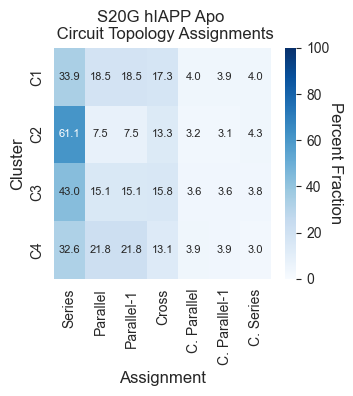

In [16]:
fig, ax = plt.subplots(figsize=(3.5,3))
heatmap = sns.heatmap(np.array(fraction_assignments)*100, cmap="Blues", annot=True, fmt="0.1f", ax=ax, annot_kws={"size": 8}, vmin=0.0, vmax=100.0)
# Customize colorbar tick sizes
cbar = heatmap.collections[0].colorbar  # Get the colorbar object
cbar.ax.tick_params(labelsize=10)  # Set the tick size
cbar.set_label("Percent Fraction", rotation=-90, labelpad=10)
# other details 
plt.title("S20G hIAPP Apo \n Circuit Topology Assignments")
plt.xlabel("Assignment")
plt.ylabel("Cluster") 
plt.yticks(np.arange(n_cluster) + 0.5, labels=["C" + str(i+1) for i in range(n_cluster)], fontsize=10)
plt.xticks(np.arange(7) +0.5, labels=["Series", "Parallel", "Parallel-1", "Cross", 
                                 "C. Parallel", "C. Parallel-1", "C. Series"], rotation=90, fontsize=10) # 7 total assignments
plt.savefig("../IAPP_compare_circuit_top_tsne/outdir_compare_circuit_top_tsne/s20g_iapp_apo_circuit_top_matrix.png", dpi=300, bbox_inches="tight")
plt.savefig("../IAPP_compare_circuit_top_tsne/outdir_compare_circuit_top_tsne/s20g_iapp_apo_circuit_top_matrix.svg", dpi=300, bbox_inches="tight")

In [17]:
# compute the matrix for the total
fraction_assignments = []
tensor = circuit_matrix 
# find the pairs 
tensor_shape = tensor.shape 
upper_triangle_indices = np.triu_indices(tensor_shape[1], k=1)

# Broadcast the indices across the first axis
broadcasted_indices = (
    np.arange(tensor_shape[0])[:, np.newaxis, np.newaxis],
    upper_triangle_indices[0],
    upper_triangle_indices[1]
)

# Use the broadcasted indices to access the values in the upper triangle
values_in_upper_triangle = tensor[broadcasted_indices]
for i in range(1,8): 
    fraction_assignments.append(np.where(values_in_upper_triangle == i)[0].size/ (np.where(values_in_upper_triangle != 0)[0].size)) # zero assignment not a contact
print(np.sum(fraction_assignments))
fraction_assignments = [fraction_assignments]

1.0


([<matplotlib.axis.XTick at 0x15d296520>,
 [Text(0.5, 0, 'Series'),
  Text(1.5, 0, 'Parallel'),
  Text(2.5, 0, 'Parallel-1'),
  Text(3.5, 0, 'Cross'),
  Text(4.5, 0, 'C. Parallel'),
  Text(5.5, 0, 'C. Parallel-1'),
  Text(6.5, 0, 'C. Series')])

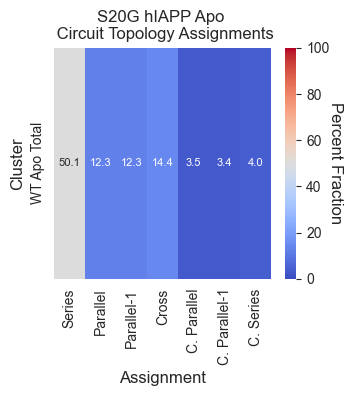

In [18]:
fig, ax = plt.subplots(figsize=(3.5,3))
heatmap = sns.heatmap(np.array(fraction_assignments)*100, cmap="coolwarm", annot=True, fmt="0.1f", ax=ax, annot_kws={"size": 8}, vmin=0.0, vmax=100.0)
# Customize colorbar tick sizes
cbar = heatmap.collections[0].colorbar  # Get the colorbar object
cbar.ax.tick_params(labelsize=10)  # Set the tick size
cbar.set_label("Percent Fraction", rotation=-90, labelpad=10)
# other details 
plt.title("S20G hIAPP Apo \n Circuit Topology Assignments")
plt.xlabel("Assignment")
plt.ylabel("Cluster") 
plt.yticks([0.5], labels=["WT Apo Total"], fontsize=10)
plt.xticks(np.arange(7) +0.5, labels=[ "Series", "Parallel", "Parallel-1", "Cross", 
                                 "C. Parallel", "C. Parallel-1", "C. Series"], rotation=90, fontsize=10) # 7 total assignments
# plt.savefig("../IAPP_compare_circuit_top_tsne/outdir_compare_circuit_top_tsne/s20g_iapp_apo_circuit_top_matrix_overall.png", dpi=300, bbox_inches="tight")
# plt.savefig("../IAPP_compare_circuit_top_tsne/outdir_compare_circuit_top_tsne/s20g_iapp_apo_circuit_top_matrix_overall.svg", dpi=300, bbox_inches="tight")

In [19]:
np.save(outdir+psystem+"_ct_assignments_total_" + ".npy", np.array(fraction_assignments)*100)

In [39]:
# """
# Created on Mon May 24 17:00:09 2021

# @author: DuaneM

# Function that creates a topological relations matrix plot for a single chain
# """
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap

# def matrix_plot(mat,protid):

#     #create custom colormap
#     newcolors = np.array([[218/255, 219/255, 228/255,1], #grey - 
#                       [131/255, 139/255, 197/255,1],    #purple S
#                       [172/255,200/255,247/255,1],       #blue P
#                       [174/255,213/255,129/255,1],         #mint green P-1
#                       [186/255, 155/255, 201/255,1],        #red purple - X
#                       [172/255, 200/255, 247/255,1],        #blue P
#                       [174/255, 213/255, 129/255,1],        #mint green
#                       [131/255,139/255, 197/255,1]])        #purple S
#     newcmp = ListedColormap(newcolors)

#     fig, ax = plt.subplots()
#     color = plt.get_cmap(newcmp, 8)

#     #plot data
#     pngmat = plt.imshow(mat,cmap=color,vmin = np.min(mat)-.5, vmax = np.max(mat)+.5)
#     ax.set_xlabel('Intramolecular contact #')
#     ax.set_ylabel('Intramolecular contact #')
#     ax.set_title(protid)
#     ax.tick_params(labelleft = True,labelbottom = True,bottom = False,left= False)
#     cbar = fig.colorbar(pngmat)
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         cbar.ax.set_yticklabels(['-','S','P','P-1','X','CP','CP-1','CS'])
# matrix_plot(mat,protid)

Save the trajectory for visualization

In [40]:
# # save the trajectory for visualization 
# for label in set(kmean_labels): 
#     temptrj = trj.slice(np.where(kmean_labels == label)[0])
#     temptrj.save_dcd(traj_dir + "circuit_top_wt_iapp_yxi1_cutoff10_cluster_of_4_ " + str(label+1)+ str(".dcd"))

It seems like running PCA outside of a notebook is giving a weird error, so we'll try it again here

In [4]:
trj = md.load(traj_path, top = top_path, stride=1)
data_type = np.uint8
pairs = 666
dim_m = np.sum(np.arange(pairs))
circuit_model = np.memmap('./outdir_s20g_apo/s20g_apo_circuit_model.dat', dtype=data_type, mode='r', shape=(trj.n_frames, dim_m))

In [5]:
from sklearn.decomposition import IncrementalPCA
from scipy import sparse
# X, _ = load_digits(return_X_y=True)
transformer = IncrementalPCA(n_components=2, batch_size=200)
# # either partially fit on smaller batches of data
# transformer.partial_fit(X[:100, :])
# or let the fit function itself divide the data into batches
X_sparse = sparse.csr_matrix(circuit_model)
X_transformed = transformer.fit_transform(X_sparse)
X_transformed.shape

(35501, 2)

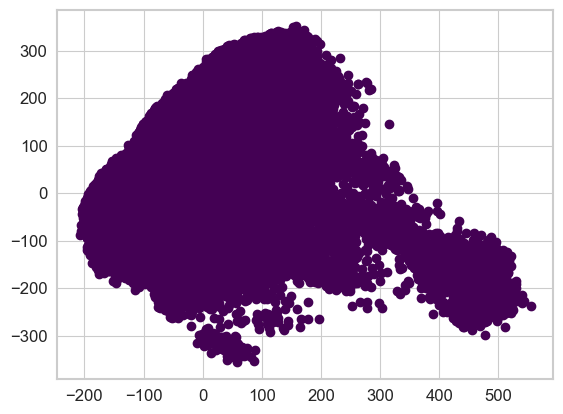

In [6]:
plt.scatter(X_transformed[:,0], X_transformed[:,1])

/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_10380/2040999810.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cdict = cm.get_cmap("nipy_spectral")._segmentdata


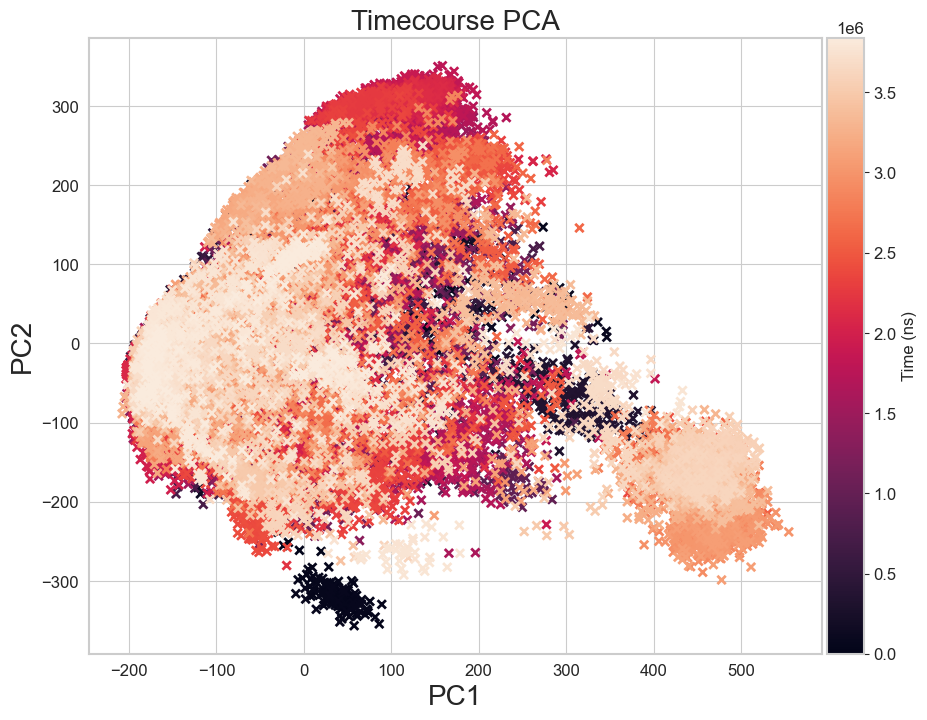

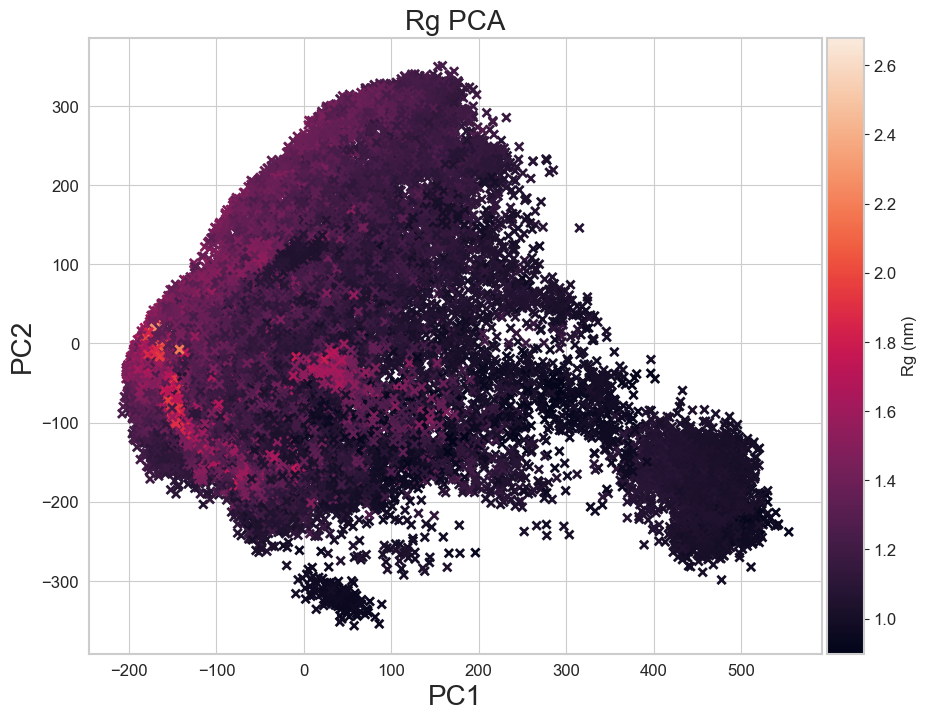

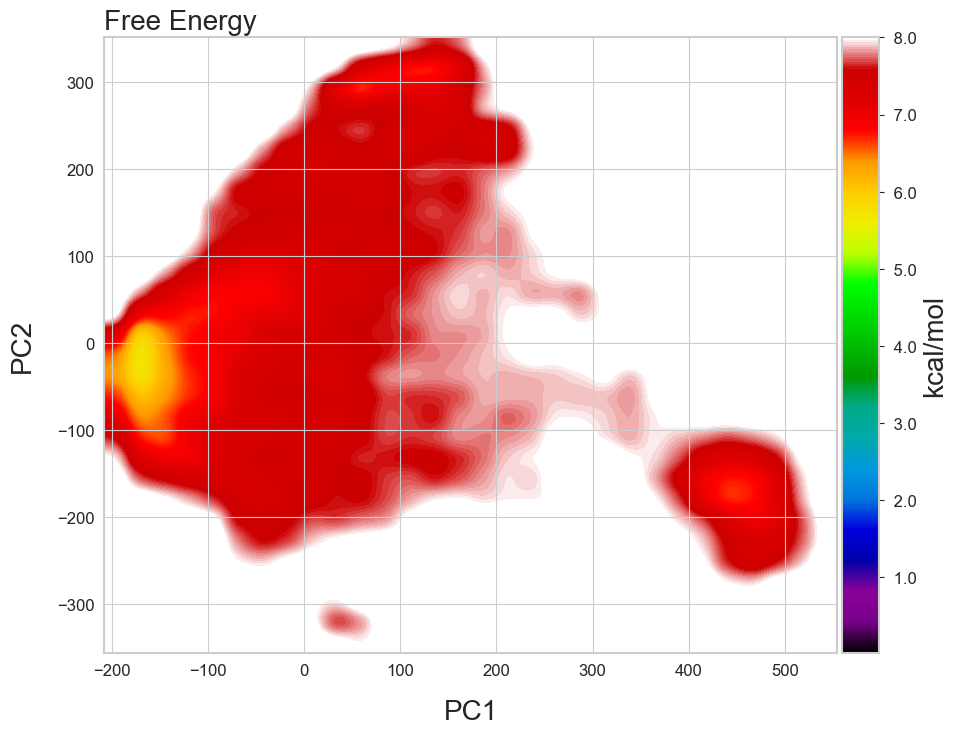

In [7]:
# make a new color map 
incPC1 = X_transformed[:,0]
incPC2 = X_transformed[:,1]
cdict = cm.get_cmap("nipy_spectral")._segmentdata
cdict["red"][-1]=(1,1,1)
cdict["green"][-1]=(1,1,1)
cdict["blue"][-1]=(1,1,1)
n_cmap = colors.LinearSegmentedColormap("new_cmap", cdict)
ax1 = plt_project_time(incPC1, incPC2, trj.n_frames, time=trj.time[-1])
ax2 = plt_project_rg(incPC1, incPC2, trj)
ax3 = plt_free_energy(incPC1, incPC2, col_map= n_cmap, title="Free Energy" ) 

KMeans clustering analysis for s20g_apo
__________________________________________________________________________________
n_cluster	silhouette score	Inertia
2	 	 0.600922		986681648.5147285


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3	 	 0.588988		415731830.48363173
4	 	 0.564786		277870029.3471051


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


5	 	 0.524069		206696177.30809492
6	 	 0.535173		164505808.07507655


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


7	 	 0.484307		143293693.90243334


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


8	 	 0.435975		124627572.07246938


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


9	 	 0.454033		109946855.07366034


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


10	 	 0.450926		97667068.82129958


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


11	 	 0.443609		89659521.26238811


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


12	 	 0.453910		81484569.03488126


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


13	 	 0.440870		75619115.80638717


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


14	 	 0.409818		70787494.2207683


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


15	 	 0.436800		66583700.03612687


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


16	 	 0.431287		62628602.532874


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


17	 	 0.407656		59144705.12884833


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


18	 	 0.395263		55878920.15092708


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


19	 	 0.370413		52223809.838691205
__________________________________________________________________________________


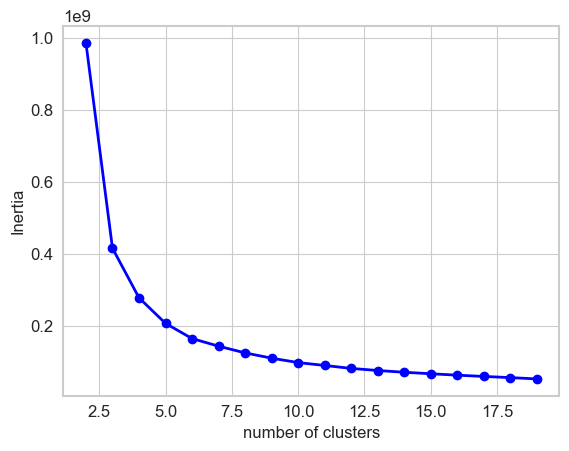

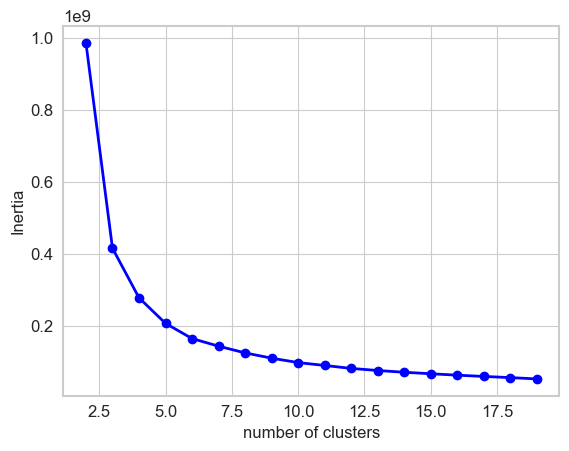

In [8]:
data = np.column_stack((incPC1,incPC2))
psystem = "s20g_apo"
bench_k_means(psystem, data, clusters = np.arange(2,20,1))

In [9]:
clusters = 4
kmeans = KMeans(n_clusters=clusters).fit(data)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


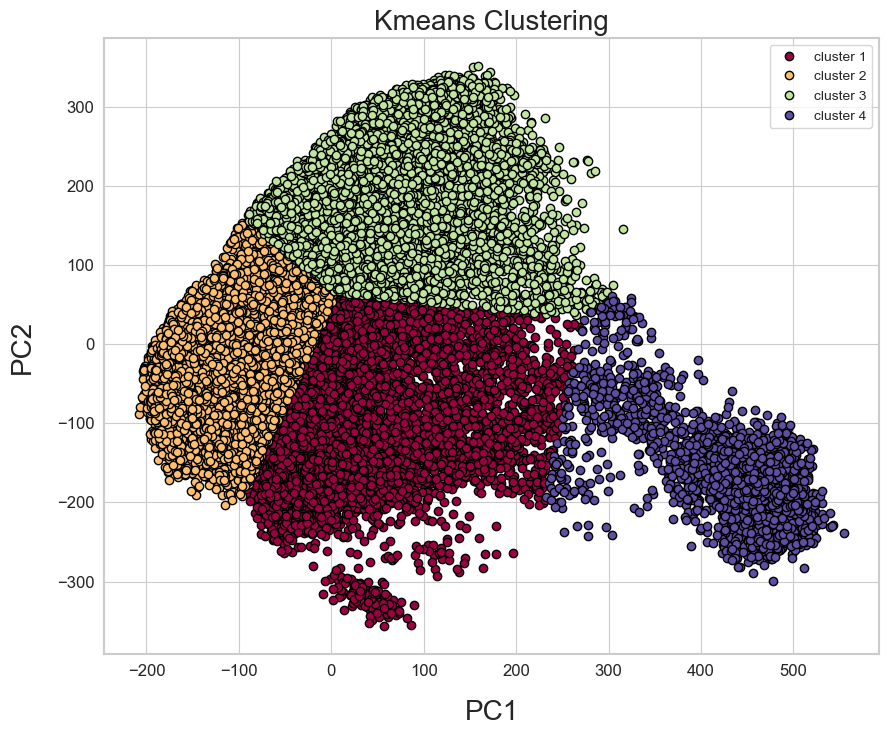

In [11]:
n_cluster=4
ax, kmean_labels, centers = kmeans_cluster(incPC1, incPC2, clusters=n_cluster, title = "Kmeans Clustering")

In [12]:
# reorder labels based off of their helicity 
h_res = []
for res in trj.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
residue_offset = 0
hres_renum = np.asarray(h_res)+residue_offset
print(hres_renum)
dssp_all = md.compute_dssp(trj, simplified=True)
dssp_all_array = np.array(dssp_all)
dssp_all_H, dssp_all_E = dssp_convert(dssp_all)

helixBB = md.load_pdb(helixpdb)
Sa_total = calc_Sa(trj, helixBB)
rg_CA = calc_rg(trj)

# generate the contact map of the whole trajectory 
contact_map, distance_map = contact_map_avg(trj, prot_len-1)

dsspH = np.copy(dssp_all)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
print(TotalH)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


/Users/f006j60/git/IAPP/analysis/IAPP_circuit_top/analysis_tools.py:114: RuntimeWarning: invalid value encountered in divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


[ 7  4  6 ...  0  0 10]


In [14]:
c_dict_reorder = {}
# reorder clusters by % helix, largest to smallest
n_cluster=4
for c in range(n_cluster): 
    print("cluster:", c+1 ,np.average(TotalH[np.where(labels==c)[0]]))
order = np.argsort([np.average(TotalH[np.where(labels==c)[0]]) for c in range(n_cluster)])[::-1]

cluster: 1 4.958013873676524
cluster: 2 4.249410630090013
cluster: 3 7.900079936051159
cluster: 4 1.707204838285564


In [15]:
# check contact maps 
prot_len=38 
trj = md.load(traj_path, top = top_path, stride=1)
contact_maps = []
distance_maps = []
populations = []
# trjs = []
for t in set(labels): 
    temptrj = trj.slice(np.where(labels == order[t])[0])
    print(temptrj.n_frames)
    populations.append(np.round(temptrj.n_frames/trj.n_frames, 2))
    # trjs.append(trj)
    # contact map 
    final_map, final_distance = contact_map_avg(temptrj, prot_len, cutoff=0.8)
    contact_maps.append(final_map)
    distance_maps.append(final_distance)

3753
5478
18664
7606


In [16]:
sequence_ol = []
for i in range(0, prot_len - 1):
    sequence_ol.append(str(trj.topology.residue(i).code))
# add the cap 
sequence_ol.append("   NH2")
print(sequence_ol)

['K', 'C', 'N', 'T', 'A', 'T', 'C', 'A', 'T', 'Q', 'R', 'L', 'A', 'N', 'F', 'L', 'V', 'H', 'S', 'G', 'N', 'N', 'F', 'G', 'A', 'I', 'L', 'S', 'S', 'T', 'N', 'V', 'G', 'S', 'N', 'T', 'Y', '   NH2']


In [17]:
# set the visualization style 
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=default_cycler)
plt.rcParams["font.size"]
plt.rcParams.update({"font.size":12, 'ytick.labelsize': '12', 'xtick.labelsize': '12', 'legend.fontsize': '10', 'axes.titlesize': '12'})
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_10380/1887692868.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


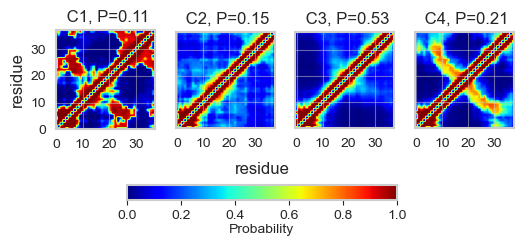

In [21]:
import seaborn as sns 
num_rows = 1
num_cols = 4

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5.4, 3), sharey=True)

# Loop through the axes and images to populate the subplots
for i, (ax, c_map) in enumerate(zip(axes.flat, contact_maps)):
    im = ax.imshow(c_map, cmap='jet', vmin=0, vmax=1.0)
    ax.grid(which='both', alpha=0.5)
    ax.set_xticks(range(0,prot_len+1, 10), range(0,prot_len+1, 10), rotation=0, size=10)
    ax.set_yticks(range(0,prot_len+1, 10), range(0,prot_len+1, 10), rotation=0, size=10)
    ax.invert_yaxis()
    ax.set_title( ' C%s' % str(i+1)+ ", P=" + str(populations[i]))

axes[0].set_ylabel("residue")
axes[0].set_ylim(0,37)
axes[0].set_xlim(0,37)
fig.text(0.5, 0.2, 'residue',rotation=0., ha='center', va='center', fontsize=12)
cax = fig.add_axes([0.25, 0.10, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')
cax.tick_params(axis="x", labelsize=10)
fig.text(0.5, 0.0, 'Probability',rotation=0., ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.savefig("./outdir_s20g_apo/s20g_iapp_apo_contact_by_cluster_40kframes.png", dpi=400, bbox_inches="tight")

# Show the plot
plt.show()

In [23]:
odir = "outdir_s20g_apo"
np.save(odir+"/incPCs.npy", X_transformed, allow_pickle=False, fix_imports=False)
# reorder clusters by total helicity 
cluster = 4

# compute helicity
trj = md.load(traj_path, top = top_path, stride=1)
h_res = []
for res in trj.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
residue_offset = 0
hres_renum = np.asarray(h_res)+residue_offset
dssp_all = md.compute_dssp(trj, simplified=True)
dssp_all_array = np.array(dssp_all)
dssp_all_H, dssp_all_E = dssp_convert(dssp_all)
dsspH = np.copy(dssp_all)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)

# reload trj for other computations
del trj 
trj = md.load(traj_path, top = top_path, stride=1)

# compute other quantities to map onto 
helixpdb = '/Users/f006j60/git/IAPP/structures/helix_s20g.pdb'

helixBB = md.load_pdb(helixpdb)
Sa_total = calc_Sa(trj, helixBB)
rg_CA = calc_rg(trj)

np.save(odir+"/Rg_total" + ".npy", rg_CA)
np.save(odir+"/Sa_total" + ".npy", Sa_total)
np.save(odir+"/H_total" + ".npy", TotalH)

# save clusters in the correct order 
c_dict_reorder = {}
# reorder clusters by % helix, largest to smallest
n_cluster=cluster
for c in range(n_cluster): 
    print("cluster:", c+1 ,np.average(TotalH[np.where(labels==c)[0]]))
order = np.argsort([np.average(TotalH[np.where(labels==c)[0]]) for c in range(n_cluster)])[::-1]

for t in range(cluster): 
    c_dict_reorder[t] = np.where(labels == order[t])[0]

with open(odir + "/kmeans_cluster_indices.pkl", "wb") as f: 
    pickle.dump(c_dict_reorder, f)

/Users/f006j60/git/IAPP/analysis/IAPP_circuit_top/analysis_tools.py:114: RuntimeWarning: invalid value encountered in divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


cluster: 1 4.958013873676524
cluster: 2 4.249410630090013
cluster: 3 7.900079936051159
cluster: 4 1.707204838285564
